In [1]:
import pandas as pd
import numpy as np
import fastquant
import datetime
import requests
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pytrends.request import TrendReq 
import hvplot

In [2]:
from collections import Counter
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier

In [3]:
# datetime.date.today()
today = date.today().strftime("%Y-%m-%d")
y_end = int(today.split('-')[0])
m_end = int(today.split('-')[1])
d_end = int(today.split('-')[2])
today

'2022-06-06'

In [4]:
date_start = "2020-07-04"
date_end = today

In [5]:
start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
end = datetime.datetime.strptime(date_end, '%Y-%m-%d')

total_days = end - start
total_days = total_days.days
total_days

702

In [6]:
BTC_1 = fastquant.get_crypto_data("BTC/USDT", date_start, date_end)
ETH_1 = fastquant.get_crypto_data("ETH/USDT", date_start, date_end)
ADA_1 = fastquant.get_crypto_data("ADA/USDT", date_start, date_end)

# Multi Index
BTC_1.columns = pd.MultiIndex.from_product([['BTC_1'], BTC_1.columns])
ETH_1.columns = pd.MultiIndex.from_product([['ETH_1'], ETH_1.columns])
ADA_1.columns = pd.MultiIndex.from_product([['ADA_1'], ADA_1.columns])

# Combine Crypto Info
price_data = pd.concat([BTC_1, ETH_1, ADA_1], axis=1)
price_data = price_data.dropna()
# price_data.head()

In [7]:
df_price = price_data.drop([
	('BTC_1', 'open'), ('BTC_1', 'high'), ('BTC_1', 'low'),
	('ETH_1', 'open'), ('ETH_1', 'high'), ('ETH_1', 'low'),
	('ADA_1', 'open'), ('ADA_1', 'high'), ('ADA_1', 'low'),
], axis=1)

df_price

BTC_1                  ETH_1                  ADA_1  \
               close        volume    close        volume    close   
dt                                                                   
2020-07-05   9069.41  34073.653627   227.56  355747.12006  0.09813   
2020-07-06   9344.20  54463.132277   241.60  864817.50700  0.10512   
2020-07-07   9257.39  34587.336678   239.39  600424.97209  0.11764   
2020-07-08   9436.06  56140.517781   246.95  958185.83708  0.12993   
2020-07-09   9232.43  48044.450645   241.98  647641.58291  0.12403   
...              ...           ...      ...           ...      ...   
2022-06-02  30452.62  56961.429280  1834.08  788784.40170  0.58710   
2022-06-03  29700.21  54067.447270  1775.12  741282.53460  0.56000   
2022-06-04  29864.04  25617.901130  1804.58  388279.45790  0.56650   
2022-06-05  29919.21  23139.928100  1806.23  371974.50610  0.56740   
2022-06-06  31373.10  68836.924560  1859.84  804250.35670  0.60910   

                          
                  volume  
dt                        
2020-07-05  3.979135e+08  
2020-07-06  4.733752e+08  
2020-07-07  7.758697e+08  
2020-07-08  1.587750e+09  
2020-07-09  8.938256e+08  
...                  ...  
2022-06-02  3.061257e+08  
2022-06-03  2.062579e+08  
2022-06-04  1.087793e+08  
2022-06-05  9.527759e+07  
2022-06-06  3.415024e+08  

[702 rows x 6 columns]

In [8]:
df_price.index = df_price.index.rename('Date')
df_price

BTC_1                  ETH_1                  ADA_1  \
               close        volume    close        volume    close   
Date                                                                 
2020-07-05   9069.41  34073.653627   227.56  355747.12006  0.09813   
2020-07-06   9344.20  54463.132277   241.60  864817.50700  0.10512   
2020-07-07   9257.39  34587.336678   239.39  600424.97209  0.11764   
2020-07-08   9436.06  56140.517781   246.95  958185.83708  0.12993   
2020-07-09   9232.43  48044.450645   241.98  647641.58291  0.12403   
...              ...           ...      ...           ...      ...   
2022-06-02  30452.62  56961.429280  1834.08  788784.40170  0.58710   
2022-06-03  29700.21  54067.447270  1775.12  741282.53460  0.56000   
2022-06-04  29864.04  25617.901130  1804.58  388279.45790  0.56650   
2022-06-05  29919.21  23139.928100  1806.23  371974.50610  0.56740   
2022-06-06  31373.10  68836.924560  1859.84  804250.35670  0.60910   

                          
                  volume  
Date                      
2020-07-05  3.979135e+08  
2020-07-06  4.733752e+08  
2020-07-07  7.758697e+08  
2020-07-08  1.587750e+09  
2020-07-09  8.938256e+08  
...                  ...  
2022-06-02  3.061257e+08  
2022-06-03  2.062579e+08  
2022-06-04  1.087793e+08  
2022-06-05  9.527759e+07  
2022-06-06  3.415024e+08  

[702 rows x 6 columns]

In [9]:
url = f"https://api.alternative.me/fng/?limit={total_days}"
response = requests.get(url)
response.raise_for_status()
data = response.json()

In [10]:
rows = []
for i in range(total_days):
	FG_index = data['data'][i]['value']
	fear_classification = data['data'][i]['value_classification']
	t = int(data['data'][i]['timestamp'])
	t = datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d')
	rows.append([t, FG_index, fear_classification])

df = pd.DataFrame(rows,columns=['Date', 'FG_index', "Fear_Classification"])
df.set_index("Date", inplace=True)
df.sort_index(ascending=True, inplace=True)
df.index = pd.to_datetime(df.index)
df_fear = df.copy()
df_fear

,FG_index,Fear_Classification
Date,,
2020-07-05,40,Fear
2020-07-06,43,Fear
2020-07-07,44,Fear
2020-07-08,44,Fear
2020-07-09,41,Fear
...,...,...
2022-06-02,10,Extreme Fear
2022-06-03,14,Extreme Fear
2022-06-04,10,Extreme Fear


In [11]:
df_fear.index

DatetimeIndex(['2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
               '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
               '2020-07-13', '2020-07-14',
               ...
               '2022-05-28', '2022-05-29', '2022-05-30', '2022-05-31',
               '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
               '2022-06-05', '2022-06-06'],
              dtype='datetime64[ns]', name='Date', length=702, freq=None)

In [12]:
df = pd.concat([df_fear, df_price], axis=1, join='inner')
df.rename(columns=''.join, inplace=True)
df.rename(columns={
"BTC_1close":"BTC_close",
"BTC_1volume":"BTC_volume",
"ETH_1close":"ETH_close",
"ETH_1volume":"ETH_volume",
"ADA_1close":"ADA_close",
"ADA_1volume":"ADA_volume",
}, inplace=True)
df

,FG_index,Fear_Classification,BTC_close,BTC_volume,ETH_close,ETH_volume,ADA_close,ADA_volume
Date,,,,,,,,
2020-07-05,40,Fear,9069.41,34073.653627,227.56,355747.12006,0.09813,3.979135e+08
2020-07-06,43,Fear,9344.20,54463.132277,241.60,864817.50700,0.10512,4.733752e+08
2020-07-07,44,Fear,9257.39,34587.336678,239.39,600424.97209,0.11764,7.758697e+08
2020-07-08,44,Fear,9436.06,56140.517781,246.95,958185.83708,0.12993,1.587750e+09
2020-07-09,41,Fear,9232.43,48044.450645,241.98,647641.58291,0.12403,8.938256e+08
...,...,...,...,...,...,...,...,...
2022-06-02,10,Extreme Fear,30452.62,56961.429280,1834.08,788784.40170,0.58710,3.061257e+08
2022-06-03,14,Extreme Fear,29700.21,54067.447270,1775.12,741282.53460,0.56000,2.062579e+08
2022-06-04,10,Extreme Fear,29864.04,25617.901130,1804.58,388279.45790,0.56650,1.087793e+08


In [13]:
pytrend = TrendReq()
kw_list=['Bitcoin', 'Ethereum', 'Cardano']
df_hist = pytrend.get_historical_interest(kw_list, year_start=2020, month_start=6, day_start=1, year_end=y_end, month_end=m_end, day_end=d_end, cat=0, geo='', gprop='', sleep=1, frequency='daily')

In [14]:
df_hist.index = df_hist.index.rename("Date")
df_hist.drop(["isPartial"], axis = 1, inplace=True)
df_hist

,Bitcoin,Ethereum,Cardano
Date,,,
2020-06-01,11,1,0
2020-06-02,16,2,0
2020-06-03,13,1,0
2020-06-04,12,1,0
2020-06-05,12,1,0
...,...,...,...
2022-06-01,32,5,2
2022-06-02,31,5,2
2022-06-03,30,5,1


In [15]:
dfh = df_hist.rename(columns={"Bitcoin":"BTC_searches", "Ethereum":"ETH_searches", "Cardano":"ADA_searches"})
dfh

,BTC_searches,ETH_searches,ADA_searches
Date,,,
2020-06-01,11,1,0
2020-06-02,16,2,0
2020-06-03,13,1,0
2020-06-04,12,1,0
2020-06-05,12,1,0
...,...,...,...
2022-06-01,32,5,2
2022-06-02,31,5,2
2022-06-03,30,5,1


In [16]:
df_complete = df.join(dfh, on=df.index, how='inner')
df_complete.drop('key_0', inplace=True, axis=1)
df_complete

,FG_index,Fear_Classification,BTC_close,BTC_volume,ETH_close,ETH_volume,ADA_close,ADA_volume,BTC_searches,ETH_searches,ADA_searches
Date,,,,,,,,,,,
2020-07-05,40,Fear,9069.41,34073.653627,227.56,3.557471e+05,0.09813,3.979135e+08,8,1,0
2020-07-06,43,Fear,9344.20,54463.132277,241.60,8.648175e+05,0.10512,4.733752e+08,9,1,0
2020-07-07,44,Fear,9257.39,34587.336678,239.39,6.004250e+05,0.11764,7.758697e+08,9,1,1
2020-07-08,44,Fear,9436.06,56140.517781,246.95,9.581858e+05,0.12993,1.587750e+09,9,1,1
2020-07-09,41,Fear,9232.43,48044.450645,241.98,6.476416e+05,0.12403,8.938256e+08,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,13,Extreme Fear,29805.83,103395.633820,1817.95,1.037841e+06,0.55160,3.554774e+08,32,5,2
2022-06-02,10,Extreme Fear,30452.62,56961.429280,1834.08,7.887844e+05,0.58710,3.061257e+08,31,5,2
2022-06-03,14,Extreme Fear,29700.21,54067.447270,1775.12,7.412825e+05,0.56000,2.062579e+08,30,5,1


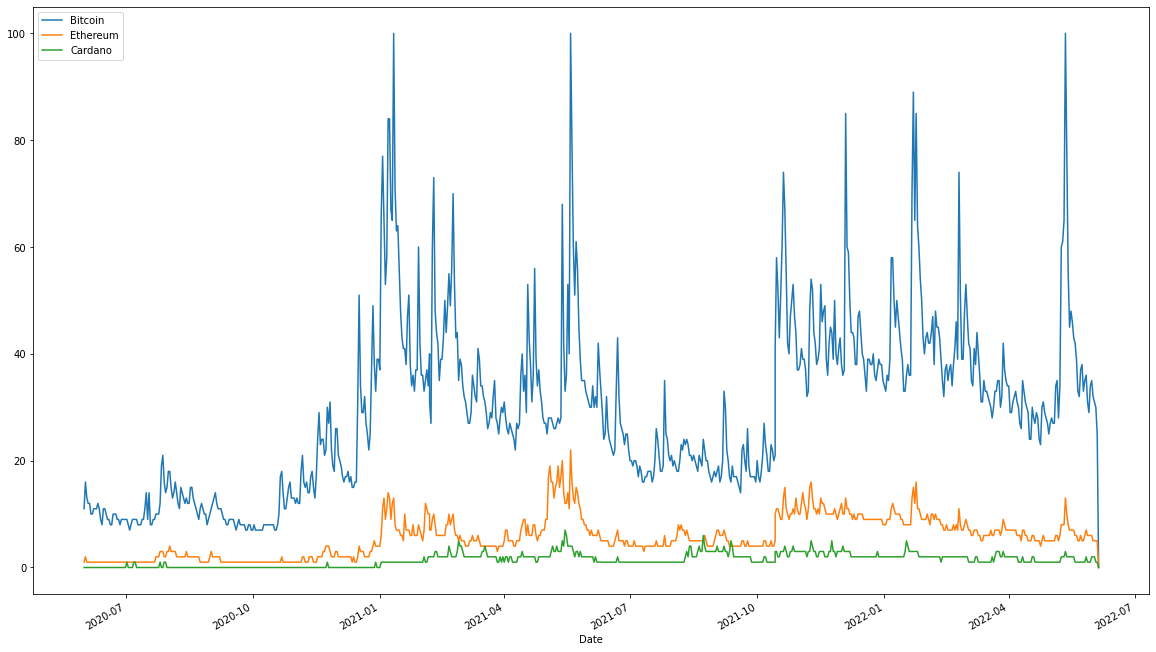

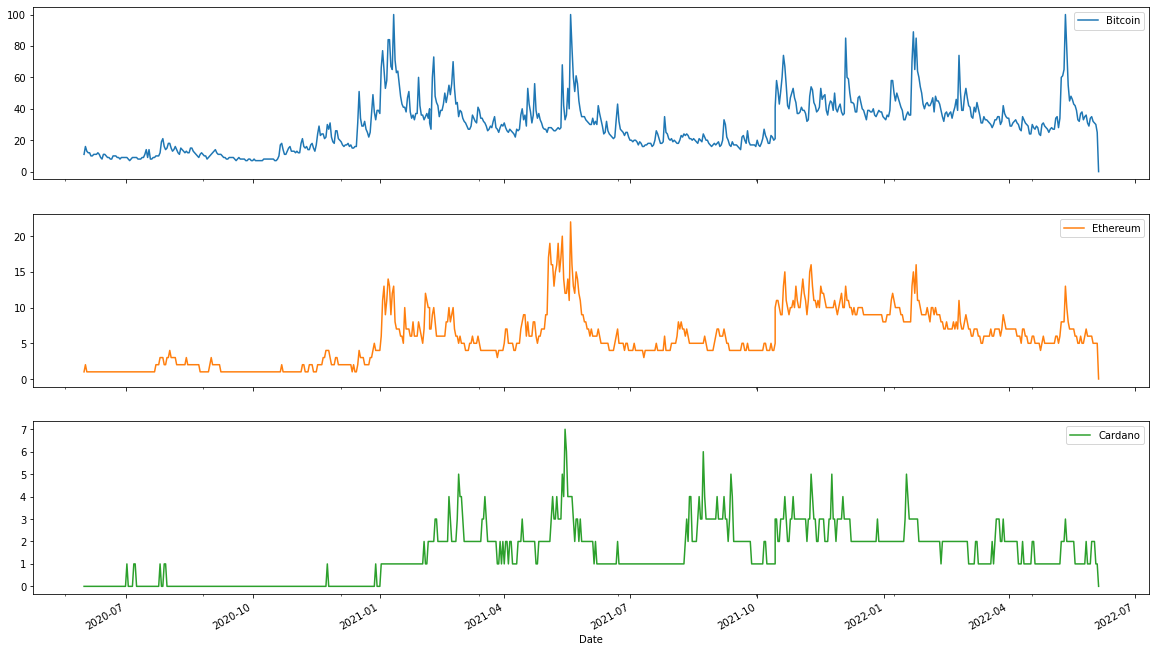

In [17]:
#visualise
#plot a timeseries chart
df_hist.plot(figsize=(20, 12))
#plot seperate graphs, using theprovided keywords
df_hist.plot(subplots=True, figsize=(20, 12));

In [18]:
df_complete['FG_index'] = df_complete['FG_index'].astype('int64')

In [19]:
df_complete.drop('Fear_Classification', inplace=True, axis=1)
df_complete

,FG_index,BTC_close,BTC_volume,ETH_close,ETH_volume,ADA_close,ADA_volume,BTC_searches,ETH_searches,ADA_searches
Date,,,,,,,,,,
2020-07-05,40,9069.41,34073.653627,227.56,3.557471e+05,0.09813,3.979135e+08,8,1,0
2020-07-06,43,9344.20,54463.132277,241.60,8.648175e+05,0.10512,4.733752e+08,9,1,0
2020-07-07,44,9257.39,34587.336678,239.39,6.004250e+05,0.11764,7.758697e+08,9,1,1
2020-07-08,44,9436.06,56140.517781,246.95,9.581858e+05,0.12993,1.587750e+09,9,1,1
2020-07-09,41,9232.43,48044.450645,241.98,6.476416e+05,0.12403,8.938256e+08,9,1,0
...,...,...,...,...,...,...,...,...,...,...
2022-06-01,13,29805.83,103395.633820,1817.95,1.037841e+06,0.55160,3.554774e+08,32,5,2
2022-06-02,10,30452.62,56961.429280,1834.08,7.887844e+05,0.58710,3.061257e+08,31,5,2
2022-06-03,14,29700.21,54067.447270,1775.12,7.412825e+05,0.56000,2.062579e+08,30,5,1


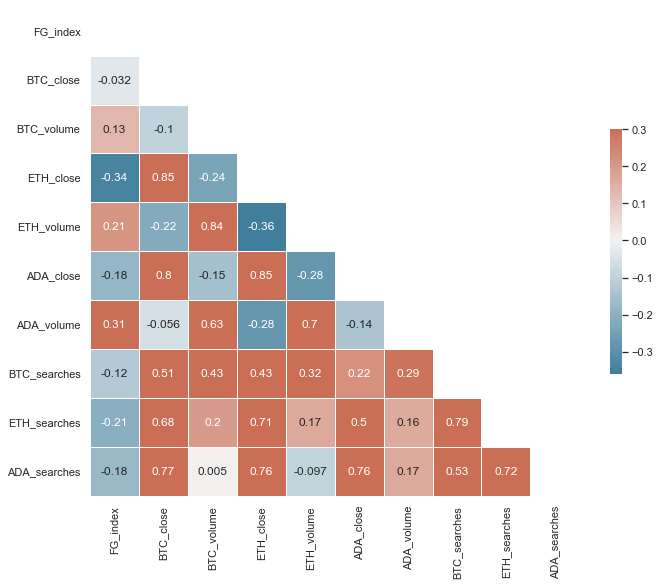

In [20]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_complete.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [21]:
df_complete

,FG_index,BTC_close,BTC_volume,ETH_close,ETH_volume,ADA_close,ADA_volume,BTC_searches,ETH_searches,ADA_searches
Date,,,,,,,,,,
2020-07-05,40,9069.41,34073.653627,227.56,3.557471e+05,0.09813,3.979135e+08,8,1,0
2020-07-06,43,9344.20,54463.132277,241.60,8.648175e+05,0.10512,4.733752e+08,9,1,0
2020-07-07,44,9257.39,34587.336678,239.39,6.004250e+05,0.11764,7.758697e+08,9,1,1
2020-07-08,44,9436.06,56140.517781,246.95,9.581858e+05,0.12993,1.587750e+09,9,1,1
2020-07-09,41,9232.43,48044.450645,241.98,6.476416e+05,0.12403,8.938256e+08,9,1,0
...,...,...,...,...,...,...,...,...,...,...
2022-06-01,13,29805.83,103395.633820,1817.95,1.037841e+06,0.55160,3.554774e+08,32,5,2
2022-06-02,10,30452.62,56961.429280,1834.08,7.887844e+05,0.58710,3.061257e+08,31,5,2
2022-06-03,14,29700.21,54067.447270,1775.12,7.412825e+05,0.56000,2.062579e+08,30,5,1


In [22]:
# df['FG_index'].dtype#.mean()

fear_mean = pd.DataFrame(df_complete["FG_index"])
fear_mean.mean()
fear_mean.max()
fear_mean.min()
fear_mean.std()

fearful_1 = fear_mean.mean() - fear_mean.std()
greedy_1 = fear_mean.mean() + fear_mean.std()

# fearful_1 = fear_mean.mean() - (0.5*fear_mean.std())
# greedy_1 = fear_mean.mean() + (0.5*fear_mean.std())

In [23]:
fearful_1 # sell when this value is exceeded
greedy_1 # buy when below this value

FG_index    78.29349
dtype: float64

In [24]:
df_ada = df_complete.drop(columns=["BTC_close", "BTC_volume", "ETH_close", "ETH_volume", "BTC_searches", "ETH_searches"])

In [25]:
df_ada

,FG_index,ADA_close,ADA_volume,ADA_searches
Date,,,,
2020-07-05,40,0.09813,3.979135e+08,0
2020-07-06,43,0.10512,4.733752e+08,0
2020-07-07,44,0.11764,7.758697e+08,1
2020-07-08,44,0.12993,1.587750e+09,1
2020-07-09,41,0.12403,8.938256e+08,0
...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2
2022-06-02,10,0.58710,3.061257e+08,2
2022-06-03,14,0.56000,2.062579e+08,1


In [26]:
# df_complete[('ADA_1','close')

In [27]:
df_ada["signal"] = 0

In [28]:
 # Create the signal to buy
df_ada.loc[(df_ada["FG_index"] <= float(fearful_1)), "signal"] = 1
df_ada.loc[(df_ada["FG_index"] >= float(greedy_1)), "signal"] = -1
df_ada

,FG_index,ADA_close,ADA_volume,ADA_searches,signal
Date,,,,,
2020-07-05,40,0.09813,3.979135e+08,0,0
2020-07-06,43,0.10512,4.733752e+08,0,0
2020-07-07,44,0.11764,7.758697e+08,1,0
2020-07-08,44,0.12993,1.587750e+09,1,0
2020-07-09,41,0.12403,8.938256e+08,0,0
...,...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2,1
2022-06-02,10,0.58710,3.061257e+08,2,1
2022-06-03,14,0.56000,2.062579e+08,1,1


In [29]:
# Calculate the daily returns using the closing prices and the pct_change function
df_ada["actual_returns"] = df_ada["ADA_close"].pct_change()

# Drop all NaN values from the DataFrame
df_ada = df_ada.dropna()

# Review the DataFrame
df_ada

,FG_index,ADA_close,ADA_volume,ADA_searches,signal,actual_returns
Date,,,,,,
2020-07-06,43,0.10512,4.733752e+08,0,0,0.071232
2020-07-07,44,0.11764,7.758697e+08,1,0,0.119102
2020-07-08,44,0.12993,1.587750e+09,1,0,0.104471
2020-07-09,41,0.12403,8.938256e+08,0,0,-0.045409
2020-07-10,44,0.11846,8.080578e+08,0,0,-0.044908
...,...,...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2,1,-0.119974
2022-06-02,10,0.58710,3.061257e+08,2,1,0.064358
2022-06-03,14,0.56000,2.062579e+08,1,1,-0.046159


In [30]:
# greedy_1
# df_ada[df_ada['signal'] == -1]
# df_ada[df_ada['signal'] == 0]
# df_ada[df_ada['signal'] == 1]

In [31]:
# if signal = 1
# if signal = -1

# money = 1000


In [32]:
# df_ada[df_ada['signal'] == -1]

,FG_index,ADA_close,ADA_volume,ADA_searches,actual_returns
Date,,,,,
2020-07-06,43,0.10512,4.733752e+08,0,0.071232
2020-07-07,44,0.11764,7.758697e+08,1,0.119102
2020-07-08,44,0.12993,1.587750e+09,1,0.104471
2020-07-09,41,0.12403,8.938256e+08,0,-0.045409
2020-07-10,44,0.11846,8.080578e+08,0,-0.044908
...,...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2,-0.119974
2022-06-02,10,0.58710,3.061257e+08,2,0.064358
2022-06-03,14,0.56000,2.062579e+08,1,-0.046159


In [51]:
df_ada.drop(columns="signal")
df_ada["signal"]

Date
2020-07-06    0
2020-07-07    0
2020-07-08    0
2020-07-09    0
2020-07-10    0
             ..
2022-06-01    1
2022-06-02    1
2022-06-03    1
2022-06-04    1
2022-06-05    1
Name: signal, Length: 702, dtype: int64

In [67]:
# ADA features
X = df_ada.drop(columns="signal")

# Create ADA target
y = df_ada["signal"]

In [34]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [80]:
# X_test#, y_train, y_test = train_test_split(X, y, random_state=1)

In [81]:
X_train

,FG_index,ADA_close,ADA_volume,ADA_searches,actual_returns
Date,,,,,
2021-05-08,73,1.62110,3.934989e+08,3,-0.019298
2021-08-01,48,1.31420,2.009788e+08,1,-0.003866
2022-05-02,27,0.78090,1.289070e+08,1,-0.010893
2021-11-12,72,2.04500,1.602522e+08,3,-0.016354
2021-07-12,20,1.31260,1.120676e+08,1,-0.026622
...,...,...,...,...,...
2020-11-27,87,0.14178,7.144013e+08,0,0.024200
2022-04-10,32,1.02700,5.199528e+07,1,-0.017225
2020-09-16,48,0.09151,2.741834e+08,0,-0.017395


In [82]:
# Create the StandardScaler instance
scaler = StandardScaler()

X_scaled = scaler.fit(X_train) # Fit the Standard Scaler with the training data

X_train_scaled = X_scaled.transform(X_train) # Scale the training and testing data
X_test_scaled = X_scaled.transform(X_test)

In [83]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions#[:10]
training_signal_predictions.shape

(526,)

In [84]:
# Create the StandardScaler instance
X_scaled = scaler.fit(X) # Fit the Standard Scaler with the training data

X = X_scaled.transform(X) # Scale the training and testing data
# X_test = X.transform(X_test)
X

array([[-0.34979192, -1.25037081,  0.24034766, -1.24473921,  1.0516494 ],
       [-0.31156151, -1.23330888,  1.10751379, -0.39966481,  1.80572944],
       [-0.31156151, -1.2165604 ,  3.43494334, -0.39966481,  1.57525648],
       ...,
       [-1.45847383, -0.63047247, -0.5254019 , -0.39966481, -0.79757593],
       [-1.61139548, -0.62161444, -0.80484554, -0.39966481,  0.11239724],
       [-1.49670425, -0.62038795, -0.84355102, -1.24473921, -0.04542008]])

In [92]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.96      0.83      0.89        93
           0       0.92      0.94      0.93       308
           1       0.88      0.93      0.90       125

    accuracy                           0.92       526
   macro avg       0.92      0.90      0.91       526
weighted avg       0.92      0.92      0.92       526



In [93]:
training_signal_predictions_1 = svm_model.predict(X)
training_signal_predictions_1.shape

(702,)

In [94]:
# # predictions_df = pd.DataFrame(index=X_test.index)
# predictions_df = pd.DataFrame(training_signal_predictions_1,index=X.index)
# predictions_df#.sum()
# # predictions_df["predicted_signal"] = training_signal_predictions


In [95]:
# # Create a new empty predictions DataFrame using code provided below.
# predictions_df = pd.DataFrame(index=X_test.index)
# predictions_df["predicted_signal"] = training_signal_predictions


# # predictions_df["actual_returns"] = df_ada["actual_returns"]
# # predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]

# # df_ada["actual_returns"]

# # predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]



# # predictions_df["trading_algorithm_returns"] = df_ada["actual_returns"] * predictions_df["predicted_signal"]

# # df_ada
# # predictions_df


# tmp_ada = df_ada.reset_index()
# tmp_pre = predictions_df.reset_index()
# # tmp_ada

# # predictions_df["trading_algorithm_returns"] = tmp_ada["actual_returns"] * tmp_pre["predicted_signal"]
# # predictions_df

In [100]:
training_signal_predictions_1.shape

(702,)

In [96]:
df_ada

,FG_index,ADA_close,ADA_volume,ADA_searches,signal,actual_returns
Date,,,,,,
2020-07-06,43,0.10512,4.733752e+08,0,0,0.071232
2020-07-07,44,0.11764,7.758697e+08,1,0,0.119102
2020-07-08,44,0.12993,1.587750e+09,1,0,0.104471
2020-07-09,41,0.12403,8.938256e+08,0,0,-0.045409
2020-07-10,44,0.11846,8.080578e+08,0,0,-0.044908
...,...,...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2,1,-0.119974
2022-06-02,10,0.58710,3.061257e+08,2,1,0.064358
2022-06-03,14,0.56000,2.062579e+08,1,1,-0.046159


In [103]:
# training_signal_predictions_1

In [105]:
df_ada["ml_signal"] = training_signal_predictions_1
df_ada

# df_ada["ml_signal"].fillna(0, inplace=True)
# df_ada
# df['DataFrame Column'] = df['DataFrame Column'].fillna(0)

,FG_index,ADA_close,ADA_volume,ADA_searches,signal,actual_returns,ml_signal
Date,,,,,,,
2020-07-06,43,0.10512,4.733752e+08,0,0,0.071232,0
2020-07-07,44,0.11764,7.758697e+08,1,0,0.119102,0
2020-07-08,44,0.12993,1.587750e+09,1,0,0.104471,0
2020-07-09,41,0.12403,8.938256e+08,0,0,-0.045409,0
2020-07-10,44,0.11846,8.080578e+08,0,0,-0.044908,0
...,...,...,...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2,1,-0.119974,1
2022-06-02,10,0.58710,3.061257e+08,2,1,0.064358,1
2022-06-03,14,0.56000,2.062579e+08,1,1,-0.046159,1


In [106]:
# predictions_df

In [107]:
# df_ada

In [108]:
# df_btc

In [109]:
# df_eth

In [110]:
# !pip install scikit-learn==0.17.1

In [111]:
# # Resample the training data with the BalancedRandomForestClassifier
# brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
# brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# brf.fit(X_train_scaled, y_train)

In [112]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

 # Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

          -1       0.96      0.79      0.87        29
           0       0.90      0.96      0.93       107
           1       0.92      0.88      0.90        40

    accuracy                           0.91       176
   macro avg       0.93      0.88      0.90       176
weighted avg       0.92      0.91      0.91       176



In [113]:
# # Create a new empty predictions DataFrame using code provided below.
# predictions_df = pd.DataFrame(index=X_test.index)
# predictions_df["predicted_signal"] = testing_signal_predictions
# predictions_df["actual_returns"] = df_ada["actual_returns"]
# predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
# predictions_df.head()

In [114]:
# df_ada['real_value'] = 0
# df_ada.drop('real_value', inplace=True, axis=1)
df_ada

,FG_index,ADA_close,ADA_volume,ADA_searches,signal,actual_returns,ml_signal
Date,,,,,,,
2020-07-06,43,0.10512,4.733752e+08,0,0,0.071232,0
2020-07-07,44,0.11764,7.758697e+08,1,0,0.119102,0
2020-07-08,44,0.12993,1.587750e+09,1,0,0.104471,0
2020-07-09,41,0.12403,8.938256e+08,0,0,-0.045409,0
2020-07-10,44,0.11846,8.080578e+08,0,0,-0.044908,0
...,...,...,...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2,1,-0.119974,1
2022-06-02,10,0.58710,3.061257e+08,2,1,0.064358,1
2022-06-03,14,0.56000,2.062579e+08,1,1,-0.046159,1


In [115]:
ada_qty = 0
dollars = 1000

In [116]:

total_ada = 0 # start with zero ADA and $1,000
dollars = 1000
real_value = 1000
i = 1
values_list = []

for index, row in df_ada.iterrows():
	values_list.append(real_value)
	# print(row)#['real_value'])
	# print(f"ADA qty = {ada_qty}; \tDollars = ${dollars}")
	
	if row["signal"] == 0:
		if ada_qty > 0:
			# price = row["ADA_close"]
			price = row["ADA_close"]
			real_value = total_ada * price
			# values_list.append(real_value)
			
		elif dollars > 0:
			real_value = dollars
			# values_list.append(real_value)
	elif row["signal"] == 1 and dollars > 0: # buy 
		price = row["ADA_close"]
		
		buy_qty = dollars / price
		total_ada += buy_qty
		
		dollars = 0
		real_value = total_ada * price
		
		# row["real_value"] = real_value
		# df_ada.iloc[i].real_value = real_value
		# df_ada.loc[row, 'real_value'] = real_value
		# print(real_value)
		# values_list.append(real_value)
		
	elif row["signal"] == -1 and total_ada > 0: # sell
		price = row["ADA_close"]
		sell_value = total_ada * price
		
		dollars += sell_value
		total_ada = 0
		real_value = dollars
		# print(real_value)
		# values_list.append(real_value)
	# else:
		
	
		
		
		# row["real_value"] = real_value
		# df_ada.iloc[i].real_value.append() = real_value
		# df_ada.loc[row, 'real_value'] = real_value
		

		# values_list.append(real_value)
		# dollars = ada_qty * price
		
	i+=1
	# print(real_value)


price = row["ADA_close"]
real_value = price * total_ada
# row["real_value"] = real_value
# df_ada.iloc[i].real_value = real_value

price = row["ADA_close"]
real_value = price * total_ada
real_values = pd.Series(data=values_list, index=df_ada.index, name="real_value")
df1 = pd.concat([df_ada, real_values], axis=1)

In [120]:
total_ada = 0 # start with zero ADA and $1,000
dollars = 1000
real_value = 1000
i = 1
values_list = []

for index, row in df_ada.iterrows():
	values_list.append(real_value)
	# print(row)#['real_value'])
	# print(f"ADA qty = {ada_qty}; \tDollars = ${dollars}")
	
	if row["ml_signal"] == 0:
		if ada_qty > 0:
			# price = row["ADA_close"]
			price = row["ADA_close"]
			real_value = total_ada * price
			# values_list.append(real_value)
			
		elif dollars > 0:
			real_value = dollars
			# values_list.append(real_value)
	elif row["ml_signal"] == 1 and dollars > 0: # buy 
		price = row["ADA_close"]
		buy_qty = dollars / price
		total_ada += buy_qty
		dollars = 0
		real_value = total_ada * price
		# row["real_value"] = real_value
		# df_ada.iloc[i].real_value = real_value
		# df_ada.loc[row, 'real_value'] = real_value
		# print(real_value)
		# values_list.append(real_value)
		
	elif row["ml_signal"] == -1 and total_ada > 0: # sell
		price = row["ADA_close"]
		sell_value = total_ada * price
		
		dollars += sell_value
		total_ada = 0
		real_value = dollars
		# print(real_value)
		# values_list.append(real_value)
	# else:
		
	
		
		
		# row["real_value"] = real_value
		# df_ada.iloc[i].real_value.append() = real_value
		# df_ada.loc[row, 'real_value'] = real_value
		

		# values_list.append(real_value)
		# dollars = ada_qty * price
		
	i+=1
	# print(real_value)


price = row["ADA_close"]
real_value = price * total_ada
real_values = pd.Series(data=values_list, index=df_ada.index, name="ml_predicted_value")
df2 = pd.concat([df1, real_values], axis=1, copy=True)

In [121]:
df_ada

,FG_index,ADA_close,ADA_volume,ADA_searches,signal,actual_returns,ml_signal
Date,,,,,,,
2020-07-06,43,0.10512,4.733752e+08,0,0,0.071232,0
2020-07-07,44,0.11764,7.758697e+08,1,0,0.119102,0
2020-07-08,44,0.12993,1.587750e+09,1,0,0.104471,0
2020-07-09,41,0.12403,8.938256e+08,0,0,-0.045409,0
2020-07-10,44,0.11846,8.080578e+08,0,0,-0.044908,0
...,...,...,...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2,1,-0.119974,1
2022-06-02,10,0.58710,3.061257e+08,2,1,0.064358,1
2022-06-03,14,0.56000,2.062579e+08,1,1,-0.046159,1


In [122]:
df2

,FG_index,ADA_close,ADA_volume,ADA_searches,signal,actual_returns,ml_signal,real_value,ml_predicted_value
Date,,,,,,,,,
2020-07-06,43,0.10512,4.733752e+08,0,0,0.071232,0,1000.0000,1000.0
2020-07-07,44,0.11764,7.758697e+08,1,0,0.119102,0,1000.0000,1000.0
2020-07-08,44,0.12993,1.587750e+09,1,0,0.104471,0,1000.0000,1000.0
2020-07-09,41,0.12403,8.938256e+08,0,0,-0.045409,0,1000.0000,1000.0
2020-07-10,44,0.11846,8.080578e+08,0,0,-0.044908,0,1000.0000,1000.0
...,...,...,...,...,...,...,...,...,...
2022-06-01,13,0.55160,3.554774e+08,2,1,-0.119974,1,1364.8652,1000.0
2022-06-02,10,0.58710,3.061257e+08,2,1,0.064358,1,1364.8652,1000.0
2022-06-03,14,0.56000,2.062579e+08,1,1,-0.046159,1,1364.8652,1000.0


In [ ]:
# len(df_ada)
# len(values_list)

In [ ]:
# df_ada.iloc[0].real_value

In [ ]:
# df_ada

In [ ]:
# # total_ada
# dollars

In [ ]:
short_window = 50
long_window = 100

signals_df = df_ada.loc[:,['ADA_close']]

signals_df


In [ ]:
short_window = 50
long_window = 100

signals_df = df_ada.loc[:,['ADA_close']]

# Generate the short and long moving averages (50 and 100 days, respectively)
signals_df['SMA50'] = signals_df['ADA_close'].rolling(window=short_window).mean()
signals_df['SMA100'] = signals_df['ADA_close'].rolling(window=long_window).mean()


# Review the DataFrame
signals_df.tail()

In [ ]:
# Generate the short and long moving averages (50 and 100 days, respectively)
signals_df['SMA50'] = signals_df['ADA_close'].rolling(window=short_window).mean()
signals_df['SMA100'] = signals_df['ADA_close'].rolling(window=long_window).mean()


# Review the DataFrame
signals_df.tail()

In [ ]:
signals_df.plot()

In [ ]:
 # Initialize the new Signal column to hold the trading signal
signals_df['Signal'] = 0.0

In [ ]:
 # Generate the trading signal 0 or 1,
# where 1 is the short-window (SMA50) is less than the long-window (SMA100)
signals_df["Signal"][short_window:] = np.where(
    signals_df["SMA50"][short_window:] < signals_df["SMA100"][short_window:], 1.0, 0.0
)

# Review the DataFrame
signals_df.iloc[95:105,:]

In [ ]:
# Calculate the points in time at which a position should be taken, 1 or -1
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Review the DataFrame
signals_df.dropna(inplace=True)
signals_df

In [ ]:
# import hvplot.pandas

# # Visualize entry positions relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['ADA_close']
entry
# entry.hvplot.scatter(
#     color='purple',
#     marker='^',
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# entry.hvplot

In [ ]:
# signals_df[signals_df['Entry/Exit'] == 1.0]['ADA_close']

In [ ]:
# pd.DataFrame(signals_df[signals_df['Entry/Exit'] == 1.0]['ADA_close'])


In [ ]:
 # Visualize exit positions relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['ADA_close']
exit
# exit.hvplot.scatter(
#     color='orange',
#     marker='v',
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400)

 # Plot the entry and exit points
# entry * exit

In [ ]:
# signals_df
signals_df[['ADA_close']]

In [ ]:
# Visualize Close price for the investment
security_close = signals_df[['ADA_close']]
security_close.hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=20,
    height=40)

In [ ]:
# Visualize the SMA50 and SMA 100 moving averages
moving_avgs = signals_df[['SMA50', 'SMA100']]
moving_avgs.hvplot(
    ylabel='Price in $',
    width=20,
    height=40)

In [ ]:
 # Plot the security_close and moving_avgs
security_close * moving_avgs

entry

In [ ]:

joined_df = pd.concat([security_close, moving_avgs, entry, exit], axis=1)

ax = joined_df.plot(ax=ax)




# Example usage:
plt.figure(figsize=(5, 5))
plt.axvline(x=10, ymin=0.10, ymax=0.70, color='b', ls='--', lw=1.5, label='axvline - % of full height')
plt.legend(bbox_to_anchor=(1.0, 1), loc='best')
plt.show()

In [ ]:
# import matplotlib.p
plt.plot()

In [ ]:
 # Overlay all four plots in a single visualization
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
	title="ADA SMA trading algo"
)

In [ ]:
 # Set the initial_capital to 1000
initial_capital = 1000
ADA_bought = initial_capital / signals_df[["ADA_close"]].iloc[0]
ADA_bought

In [ ]:
# signals_df[["ADA_close"]].iloc[0]

In [ ]:
 # Create a column named "Position" by multiplying the share_size by the Signal
# Sell a position (1 shares) when the dual moving average crossover Signal equals 1 (SMA50 is less than SMA100)
# Buy a position (500 shares) when the dual moving average crossover Signal equals 0 (SMA50 is greater than SMA100)
signals_df["Position"] = ADA_bought * signals_df["Signal"]

# Review the DataFrame
signals_df.tail()

In [ ]:
 # Find the points in time where a 500 share position is bought or sold
signals_df["Entry/Exit Position"] = signals_df["Position"].diff()

# Review the DataFrame
signals_df.tail()

In [ ]:
 # Create a Portfolio Holdings column by multiplying the Close price by the Position
signals_df["Portfolio Holdings"] = signals_df["ADA_close"] * signals_df["Position"]


# Review the DataFrame
signals_df.tail()
# signals_df

In [ ]:
 # To calculate Portfolio Cash, subtract the cumulative sum of the trade cost/proceeds from the initial_capital
# The trade cost proceeds are calculated by multiplying the Close price by Entry/Exit Position
signals_df["Portfolio Cash"] = (
    initial_capital - (signals_df["ADA_close"] * signals_df["Entry/Exit Position"]).cumsum()
)

# Review the DataFrame
signals_df.tail()

In [ ]:
 # Calculate the Portfolio Total value by adding Portfolio Cash and Portfolio Holdings 
signals_df["Portfolio Total"] = signals_df["Portfolio Cash"] + signals_df["Portfolio Holdings"]

# Review the DataFrame
signals_df.tail()

In [ ]:
 # Calculate the Portfolio Daily Returns based on the Portfolio Total
signals_df["Portfolio Daily Returns"] = signals_df["Portfolio Total"].pct_change()

# Review the DataFrame
signals_df.tail()

In [ ]:
 # Calculate the Portfolio Cumulative Returns based on the Portfolio Daily Returns
signals_df["Portfolio Cumulative Returns"] = (
    1 + signals_df["Portfolio Daily Returns"]
).cumprod() - 1

# Review the DataFrame
signals_df.tail()

In [ ]:
# Visualize the entry positions relative to the Portfolio Total
entry = signals_df[signals_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the exit positions relative to the Portfolio Total
exit = signals_df[signals_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize Portfolio Total for the investment
total_portfolio_value = signals_df[["Portfolio Total"]].hvplot(
    line_color="lightgray", 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Overlay the entry, exit and total_portfolio_value plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="SMA positions",
    yformatter='%.0f'
)